# LAB 1 


Code for testing and modeling Powershell Obscuration classification using a provided 
data set with predetermined features. PCA may be the preferred method for the unsupervised approach as 
the data provided is not labled. 

Current Models do not include the "sha1" and "fpath" columns


In [1]:
import sys
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set(style='white')

%matplotlib inline

In [2]:
# Define Global variables
# Define Global

#original_data_path = "../dataset/all.csv" # this file is originally zipped
original_data_path = "../dataset/all_with_labels.csv" # With Labels 

# Some columns are empty for future use. Set to False to not include them
include_unused_columns = False 

# Define unused columns here
unused_columns = ['vt_harmless', 'vt_undetected', 'vt_malicious', 'vt_suspicious',
				  'avclass_name', 'obf_name']

# Remove the string columns sha1 and fpath
include_sha1_fpath = False

# Remove them from the list if set to False 
if include_sha1_fpath == False:
	unused_columns.append('sha1')
	unused_columns.append('fpath')

+ Create a function that imports the dataset and returns a workable formatted version

In [3]:
def create_workable_data(file_path, lst_unused_columns):
	'''import the dataset and format the data into a pandas dataframe.
	+ Read in CSV as dataframe
	+ Remove extra header if there is one 
	+ Remove unused columns if set 
	+ Typecast DataTypes to string and integers
	+ Returns Pandas DataFrame object'''
	try:
		pd_df = pd.read_csv(file_path) # Read in CSV as dataframe
	except FileNotFoundError():
		print("Could not find data file. Make sure the file is unzipped...")
		sys.exit(1)
		
	# Remove Duplicates
	pd_df.drop_duplicates('sha1', inplace=True)
		
	# Check to see if duplicate header is present. Remove if there is 
	if pd_df.at[0, 'sha1'] == 'sha1':
		pd_df = pd_df.iloc[1:] # .iloc[] integer-loc based indexing for selecting by position 
		
	# Remove unused columns if global var "include_unused_columns" is set to False
	if include_unused_columns == False:
		pd_df = pd_df.drop(columns=lst_unused_columns)

	# Convert all to float 
	for col in pd_df.columns.tolist():
		pd_df[col] = pd_df[col].astype(float)
	
	return(pd_df)

Create reusable function to remove rows from dataframe that are equal to or lower than the value provided. Initially used to remove scripts that
have no length to them. 

In [4]:
def remove_df_rows(data_as_df, char_limit):
    '''Function to remove rows based on the char_limit. char_limit is depicted by
    the doc_char_count feature. 
    @Params:
    - data_as_df (Pandas DataFrame): Data set
    - char_limit (int): Will remove all rows less than or equal to this value
    '''
    working_data = data_as_df # Copy to return
    indx_to_remove = [] # List of index values to remove from DF
    # Find Index's of rows that match the use case 
    for indx in working_data.index.values:
        if float(working_data.at[indx, 'doc_char_count']) <= char_limit:
            indx_to_remove.append(indx)
        else:
            pass

    print('{} row(s) removed that had a document char lenth of {} or less.'.format(
        len(indx_to_remove), char_limit
    ))

    return(working_data.drop(indx_to_remove))

Create Initial dataframes to work with!

In [5]:
data_df = create_workable_data(original_data_path, unused_columns) # Create a Data Frame from the csv 
data_df = remove_df_rows(data_df, 0) # Remove rest of the empty rows 

'''
Note: data_df will be the original data and should not be modified as it will be used
    to compare to delta DataFrames.
'''
# Create Delta Data Frame. This will be used for modifications
delta_data_df = data_df.copy()

1 row(s) removed that had a document char lenth of 0 or less.


In [6]:
# Only keep the rows that have a "is_obf" of 1 or 3.
# Delta
delta_data_df['is_obf'] = pd.to_numeric(delta_data_df['is_obf'], downcast='integer')
delta_data_df.drop(delta_data_df.loc[delta_data_df['is_obf']==2].index, inplace=True)

# Original
data_df['is_obf'] = pd.to_numeric(data_df['is_obf'], downcast='integer')
data_df.drop(data_df.loc[data_df['is_obf']==2].index, inplace=True)

Creating more of an investigative function that will show how much of the data is represented depending on a user selected interval. Say you want to know the percentage of script char counts with intervals of 500 to 10,000. It will print out the percentage of 1-500, 501-1000,... 10000-above.

In [7]:
# Show distribution in text first because the current data does not translate over to histogram  
def show_freq_list(data, interval, max):
    """Show a list of amount of scripts that fall between the frequency intervals
    from 0 to the user defined interval. The max set the top limit, as in anything 
    above the max value will be included in the '<Max> and Above'.
    """
    max_limit = max
    low_cnt = 0
    high_cnt = interval
    name_list = []
    count_list = []
    percent_list = [] # Percentage of scripts covered
    
    print("Char Count\t|\tNum of Scripts\t|\tPercent of Data")
    print("----------\t|\t--------------\t|\t---------------")

    while low_cnt < max_limit:
        low_cnt = low_cnt + 1
        name_list.append(str(low_cnt) + '-' + str(high_cnt))

        num_of_instances = len(
            data_df[(data_df['doc_char_count'] >= low_cnt) & (data_df['doc_char_count'] <= high_cnt)]
        )

        count_list.append(num_of_instances)
        percent_list.append(num_of_instances / data.shape[0])

        print('{}\t\t\t{}\t\t{}'.format(name_list[-1], count_list[-1], percent_list[-1]))

        # Update values
        low_cnt = low_cnt + interval -1
        high_cnt = high_cnt + interval

    print('above {}\t\t\t{}\t\t{}'.format(
        max_limit, 
        data.shape[0] - sum(count_list), 
        (data.shape[0] - sum(count_list))/data.shape[0])
    )
    #TODO: Create aggregate. Ex. 1-100: %   |   101-max: %   | max-above: %

show_freq_list(delta_data_df, 1000, 10000)

Char Count	|	Num of Scripts	|	Percent of Data
----------	|	--------------	|	---------------
1-1000			1270		0.12205670350792888
1001-2000			1308		0.12570879384911102
2001-3000			1241		0.11926958193176357
3001-4000			803		0.07717443536761172
4001-5000			550		0.05285920230658337
5001-6000			415		0.03988467083133109
6001-7000			370		0.035559827006247
7001-8000			294		0.02825564632388275
8001-9000			258		0.024795771263815474
9001-10000			274		0.02633349351273426
above 10000			3622		0.34810187409899085


## EDA 

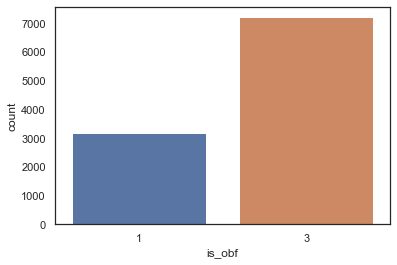

In [8]:
# Show the distribution of obscuration. 1-Known Obscuration, 3-Known Unobscuration
ax = sns.countplot(x="is_obf", data=data_df)


### Analysis

In [9]:
# Remove keyword count features to reduce features for right now
delta_data_df = delta_data_df.loc[:, :'doc_mcomment_count']
data_df = data_df.loc[:, :'doc_mcomment_count']

In [10]:
# print out the summary of our pandas DataFrame. Ignore the 'is_obf' column. That is the target column. 
data_df.describe()

,is_obf,char_hash_count,char_paren_count,char_brack_count,char_brace_count,char_bkslash_count,char_fwslash_count,char_dollar_count,char_squote_count,char_dquote_count,...,char_pipe_count,char_uscore_count,char_amp_count,char_excl_count,doc_char_count,doc_avg_line_len,doc_min_line_len,doc_max_line_len,doc_line_count,doc_mcomment_count
count,10405.000000,1.040500e+04,10405.000000,1.040500e+04,10405.000000,10405.000000,10405.000000,10405.000000,10405.000000,10405.000000,...,10405.000000,10405.000000,10405.000000,10405.000000,1.040500e+04,1.040500e+04,10405.000000,1.040500e+04,10405.000000,10405.000000
mean,2.386833,3.001259e+02,171.500529,3.327098e+02,999.266506,6.104277,133.038539,569.748390,136.621720,53.762902,...,6.038347,24.160884,11.921961,61.755983,3.337867e+04,8.866384e+03,1.207785,1.824286e+04,282.826526,1.730802
std,0.922194,1.619296e+04,1994.166315,1.895345e+04,14359.568649,73.257227,6091.243722,7652.507552,947.655745,256.344755,...,37.157116,230.984057,177.716609,1694.258059,1.548391e+05,7.219357e+04,44.410101,1.473726e+05,1246.047428,14.301771
min,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000e+00,0.000000e+00,0.000000,0.000000e+00,1.000000,0.000000
25%,1.000000,2.000000e+00,16.000000,8.000000e+00,10.000000,0.000000,0.000000,8.000000,3.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,2.020000e+03,3.151562e+01,0.000000,1.240000e+02,39.000000,0.000000
50%,3.000000,6.000000e+00,38.000000,2.200000e+01,26.000000,0.000000,4.000000,34.000000,12.000000,12.000000,...,2.000000,2.000000,0.000000,0.000000,5.072000e+03,4.200000e+01,1.000000,1.870000e+02,94.000000,0.000000
75%,3.000000,2.700000e+01,106.000000,6.200000e+01,78.000000,3.000000,18.000000,92.000000,50.000000,44.000000,...,5.000000,8.000000,0.000000,1.000000,1.577400e+04,7.384265e+01,1.000000,3.710000e+02,219.000000,2.000000
max,3.000000,1.280462e+06,165592.000000,1.918417e+06,580658.000000,6781.000000,604928.000000,290318.000000,46686.000000,15028.000000,...,2494.000000,5500.000000,5607.000000,136296.000000,6.080698e+06,3.040348e+06,4499.000000,6.080694e+06,49857.000000,846.000000


Okay there is a lot of scientific notation present. Huge numbers and small. One way we can try to normalize the data is to make the counts of features a ratio of number of chars are in a documents. This method may help us mitigate cases where very very large scripts can skew the data.

The function below should modify the data frame to transform all features we want transformed excluding the columns that would otherwise have no effect because of num of chars in a file. It can be skipped by setting the 'data_to_percent' variable to False. 

In [11]:
# Option to modify the data to turn feature values from count to ratio
data_to_percent = True

def transform_feature_count_to_percent(dataframe):
    """Function to turn certain features from count to percentage (ratio) values. It
    does this be deviding the feature value by the document char count. Document char count
    is also a feature within the dataset and will be ignored along with some other features.
    This transformation will help try to mitigate the affects of scaling, because as the script 
    gets larger than then char count would go up too. 

    Returns transformed Pandas DataFrame 
    """
    working_data = dataframe  # Create DF to return
    char_count_col_name = 'doc_char_count'

    # List of features that would not likely be susceptible to scaling issues
    non_sus_feat_lst = ['doc_char_count', 'doc_avg_line_len', 'doc_min_line_len',
                        'doc_line_count', 'doc_mcomment_count', 'doc_entropy', 'is_obf',
                        'doc_max_line_len']

    # Start looping through the working data and change the values 
    for row in list(working_data.index.values):
        for col_name in working_data.columns.tolist():
            # Skip columns that we don't want to modify
            if col_name not in non_sus_feat_lst:
                working_data.at[row, col_name] = float(
                    int(working_data.at[row, col_name]) / int(working_data.at[row, char_count_col_name])
                    ) * 100
            else:
                pass

    return(working_data)

# Transform if data_to_percent is true
if data_to_percent:
    delta_data_df = transform_feature_count_to_percent(delta_data_df)

Okay now let's check if it made a difference. Print out the Description of the DataFrame if the transformation was performed. 

In [12]:
delta_data_df.describe()

,is_obf,char_hash_count,char_paren_count,char_brack_count,char_brace_count,char_bkslash_count,char_fwslash_count,char_dollar_count,char_squote_count,char_dquote_count,...,char_pipe_count,char_uscore_count,char_amp_count,char_excl_count,doc_char_count,doc_avg_line_len,doc_min_line_len,doc_max_line_len,doc_line_count,doc_mcomment_count
count,10405.000000,10405.000000,10405.000000,10405.000000,10405.000000,10405.000000,10405.000000,10405.000000,10405.000000,10405.000000,...,10405.000000,10405.000000,10405.000000,10405.000000,1.040500e+04,1.040500e+04,10405.000000,1.040500e+04,10405.000000,10405.000000
mean,2.386833,0.467556,1.048191,0.642976,1.007465,0.084573,0.208984,1.126563,0.740594,0.534948,...,0.077549,0.108470,0.020240,0.037667,3.337867e+04,8.866384e+03,1.207785,1.824286e+04,282.826526,1.730802
std,0.922194,1.473846,0.811711,0.767225,1.582421,0.251177,0.722850,1.044011,1.414740,0.670603,...,0.192461,0.244304,0.128157,0.613756,1.548391e+05,7.219357e+04,44.410101,1.473726e+05,1246.047428,14.301771
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000e+00,0.000000e+00,0.000000,0.000000e+00,1.000000,0.000000
25%,1.000000,0.041220,0.469484,0.175572,0.319616,0.000000,0.000000,0.448718,0.035322,0.026196,...,0.000000,0.000000,0.000000,0.000000,2.020000e+03,3.151562e+01,0.000000,1.240000e+02,39.000000,0.000000
50%,3.000000,0.163310,0.960439,0.500469,0.704225,0.000000,0.066534,1.036970,0.255951,0.343397,...,0.017323,0.026035,0.000000,0.000000,5.072000e+03,4.200000e+01,1.000000,1.870000e+02,94.000000,0.000000
75%,3.000000,0.368550,1.512287,0.887741,1.123990,0.054209,0.284424,1.593252,0.808625,0.829876,...,0.098705,0.120192,0.000000,0.008773,1.577400e+04,7.384265e+01,1.000000,3.710000e+02,219.000000,2.000000
max,3.000000,41.340451,27.379720,31.549289,18.997109,5.555556,34.284913,13.328027,20.175647,19.317177,...,12.500000,4.937861,2.219415,34.571970,6.080698e+06,3.040348e+06,4499.000000,6.080694e+06,49857.000000,846.000000


Optional to drop features (char_count) because we applied the transformation.
Also drop line feature because they do not scale to the char counts. This will be investigated later.

In [13]:
drop_features_delta = True
drop_line_features = True

if data_to_percent:
    if drop_features_delta:
        delta_data_df.drop('doc_char_count', axis=1, inplace=True)

if drop_line_features:
    line_features = ['doc_avg_line_len', 'doc_min_line_len', 'doc_line_count', 'doc_max_line_len', 
                     'doc_mcomment_count']
    delta_data_df.drop(line_features, axis=1, inplace=True)

### Charts

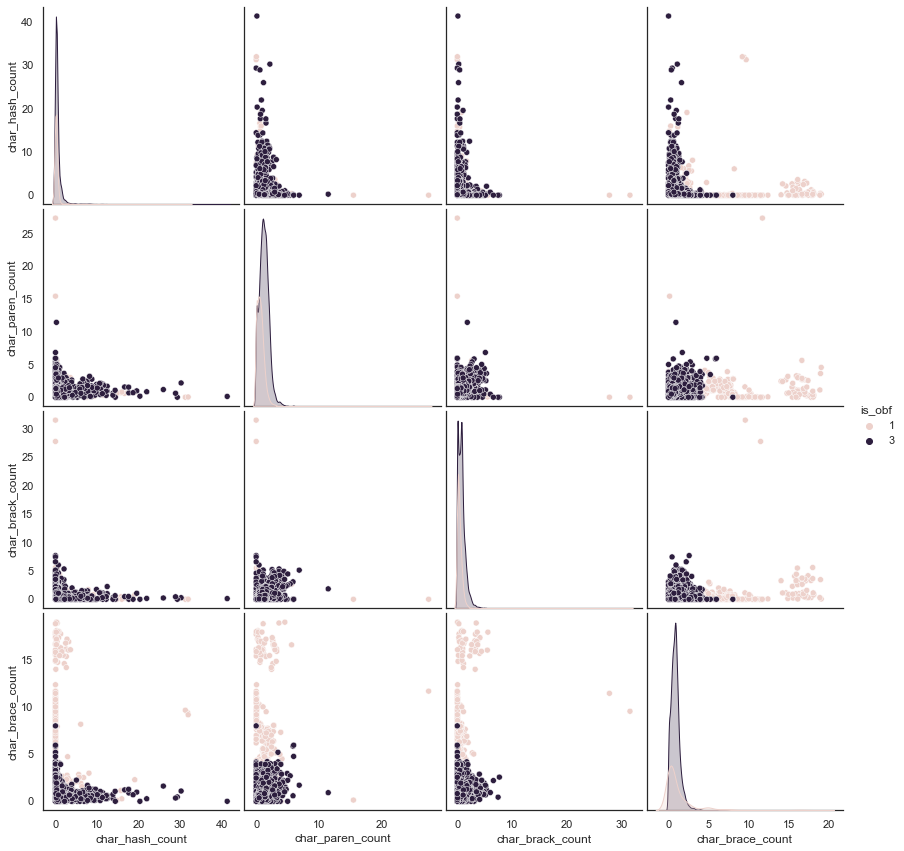

In [14]:
# Pair Plots
sample = delta_data_df.loc[:, :'char_brace_count']
sns.pairplot(sample, hue="is_obf", height=3)

Correlation matrix

<AxesSubplot:>

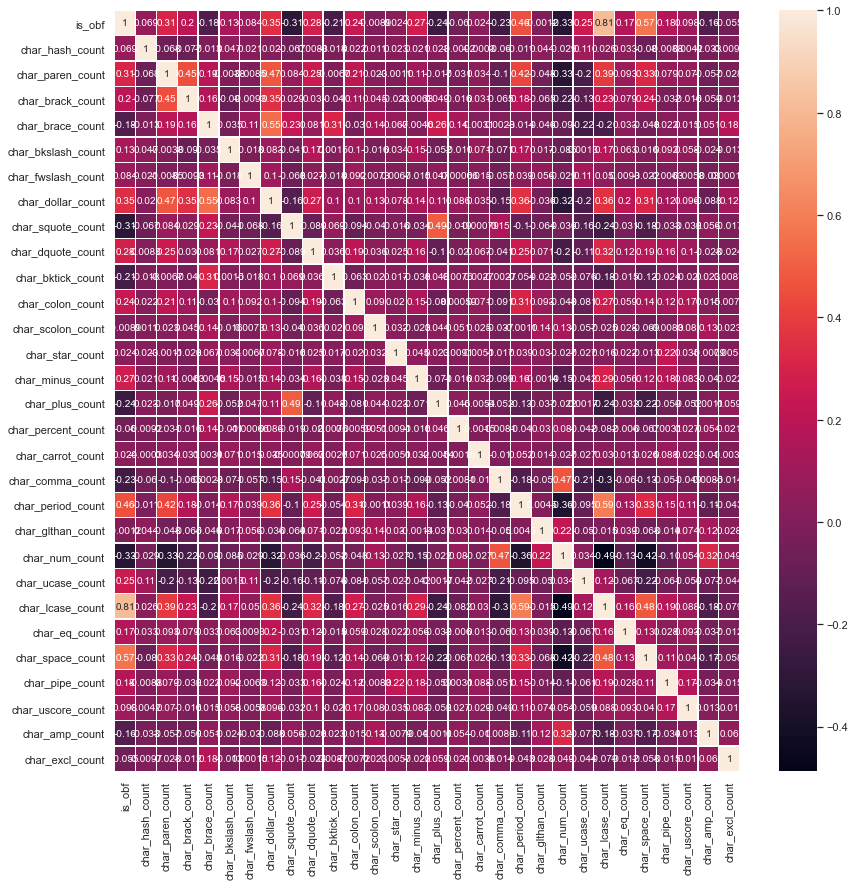

In [15]:
# Creating a correlation matrix heatmap

# Make the correlation matrix from delta dataframe
delta_data_corr_mtrx = delta_data_df.corr()
# Display
fig, ax = plt.subplots(figsize=(14,14))      
sns.heatmap(delta_data_corr_mtrx, annot=True, linewidths=.3, ax=ax)

<AxesSubplot:xlabel='is_obf', ylabel='char_space_count'>

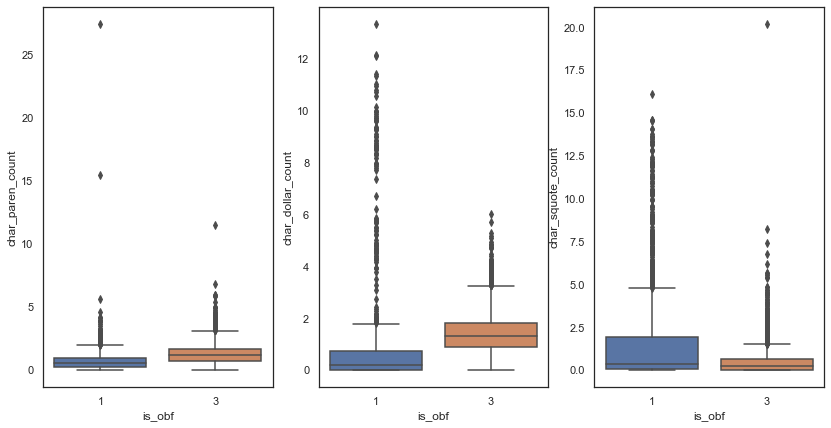

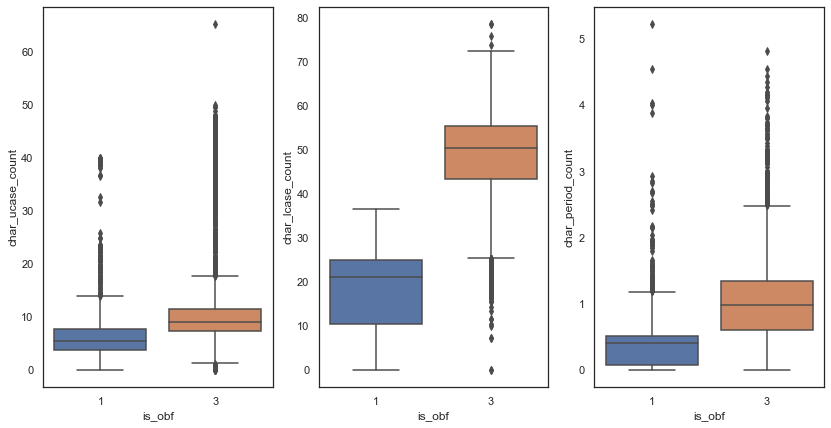

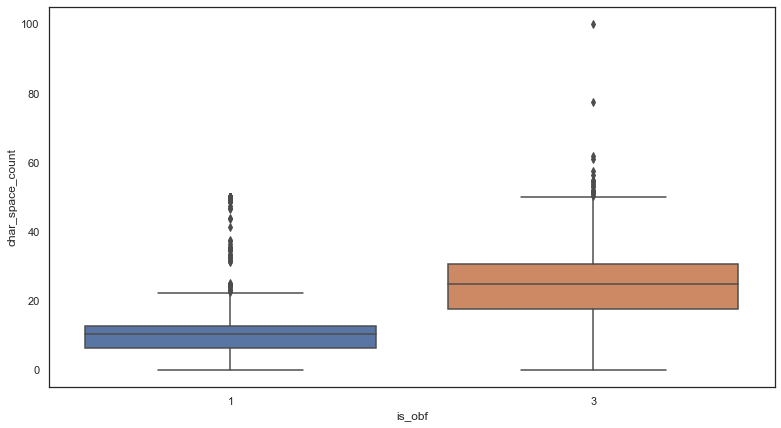

In [16]:
# Box Plots
''' # Loop to display all
for grph, col in enumerate(delta_data_df.columns):
    plt.figure(grph)
'''
# Noteable boxplots
fig, axs = plt.subplots(ncols=3)
fig.set_figheight(7); fig.set_figwidth(14)
sns.boxplot(x=delta_data_df['is_obf'], y=delta_data_df['char_paren_count'], ax=axs[0])
sns.boxplot(x=delta_data_df['is_obf'], y=delta_data_df['char_dollar_count'], ax=axs[1])
sns.boxplot(x=delta_data_df['is_obf'], y=delta_data_df['char_squote_count'], ax=axs[2])

fig, axs = plt.subplots(ncols=3)
fig.set_figheight(7); fig.set_figwidth(14)
sns.boxplot(x=delta_data_df['is_obf'], y=delta_data_df['char_ucase_count'], ax=axs[0])
sns.boxplot(x=delta_data_df['is_obf'], y=delta_data_df['char_lcase_count'], ax=axs[1])
sns.boxplot(x=delta_data_df['is_obf'], y=delta_data_df['char_period_count'], ax=axs[2])

fig, axs = plt.subplots(ncols=1)
fig.set_figheight(7); fig.set_figwidth(13)
sns.boxplot(x=delta_data_df['is_obf'], y=delta_data_df['char_space_count'], ax=axs)

Let's run t-tests on all the remaining features for statistical significance. Assumptions are that for each feature that the means, variance, and 'n' values will be different. This will lead us to set the 'equal_var' argument to False. This means we are performing a Welch's T-Test. The default is set to two-sided. 

In [17]:
# Create a function that will perform a t-test on all the features and return an dictionary of 
# the features along with calculated p-value
def feature_t_tests(dataframe):
    """Takes in pandas df and performs a t-test on all columns that is not
    the target column. The target (is_obf) column what we are testing on.
    Returns Python Dictionary of results."""
    results = dict() # Holds the results and what we are returning

    # Create two data frames that seperate the is_obs
    obs_is_one = dataframe.copy()
    obs_is_one.drop(obs_is_one.loc[obs_is_one['is_obf']==3].index, inplace=True)

    obs_is_three = dataframe.copy()
    obs_is_three.drop(obs_is_three.loc[obs_is_three['is_obf']==1].index, inplace=True)

    # Loop through the list of columns 
    for feat in dataframe.columns.tolist():
        if feat != 'is_obf': # Don't test for the target column
            # Perform and get p-value from Welche's T-Test
            p_val = stats.ttest_ind(obs_is_one[feat], obs_is_three[feat], equal_var=False)[1]
            # Add to dictionary
            results[feat] = p_val

    return(results)

p_values_delta_data = feature_t_tests(delta_data_df)
# For fun we can run this on the original dataset too
p_values_orig_data = feature_t_tests(data_df)

# Print Results for Features and p-values sorted by accending
for feat in sorted(p_values_delta_data, key=p_values_delta_data.get, reverse=False):
    print(feat, '\t', p_values_delta_data[feat]) 

char_period_count 	 0.0
char_lcase_count 	 0.0
char_space_count 	 0.0
char_minus_count 	 9.378927337022417e-274
char_dquote_count 	 2.3269883717919076e-264
char_paren_count 	 8.981124671614051e-217
char_dollar_count 	 1.394846196656598e-193
char_ucase_count 	 1.7685175775633388e-168
char_colon_count 	 1.001254916176178e-152
char_pipe_count 	 8.639622349794347e-142
char_num_count 	 4.167959254583747e-120
char_squote_count 	 3.5387336097195284e-117
char_eq_count 	 9.605551839756967e-101
char_brack_count 	 3.303295745479174e-77
char_plus_count 	 1.6127236143185144e-64
char_bkslash_count 	 1.0409048714913284e-59
char_comma_count 	 3.05340948511828e-57
char_bktick_count 	 5.863580862416314e-46
char_brace_count 	 1.3507253870272087e-36
char_amp_count 	 1.7357700333349393e-29
char_uscore_count 	 2.448870502672749e-25
char_hash_count 	 7.319231399604293e-13
char_fwslash_count 	 7.040997562565199e-10
char_percent_count 	 4.9101276509080494e-05
char_excl_count 	 0.00016270487570941997
char_star_

## PCA / LDA

A principle component analysis will be used for this data. We are treating it as an unsupervised approach. Lables were added later to the data to hopefully discover some clustering. We will also use original data along side the delta data for comparison. 

In [18]:
# Lets create a copy of and drop that target column so it doesn't intefere with the PCA 
target_df = pd.DataFrame(data_df['is_obf']) # They are both the same so I only need one.
target_nd = pd.DataFrame(data_df['is_obf']).to_numpy() # They are both the same so I only need one.
target_nd = target_nd.ravel() 
# Drop column from DF's 
data_df = data_df.drop(columns=['is_obf'])
delta_data_df = delta_data_df.drop(columns=['is_obf'])

Creating a simple function to determine the best n components for PCA 

In [19]:
# Creating a function to find the optimal n_components for PCA 
def find_opt_n_components(data_set):
	'''Find the number of components that can explain the most data.'''
	set_percentage = .98 # Percentage of data explained

	# The range is the number of components to test
	for comp in range(2, data_set.shape[1]):
		pca = PCA(n_components = comp, random_state=42)
		pca.fit(data_set)
		comp_check = pca.explained_variance_ratio_
		final_comp = comp
		
		if comp_check.sum() >= set_percentage:
			break

	return(final_comp)

opt_n_delta_data = find_opt_n_components(delta_data_df)
print("Optimal n_components for the delta data is {}".format(opt_n_delta_data))

opt_n_data = find_opt_n_components(data_df)
print("Optimal n_components for the original data is {}".format(opt_n_data))

Optimal n_components for the delta data is 6
Optimal n_components for the original data is 5


Now we can create some PCA with our n_components. We will make one for the delta and the original. 

In [20]:
# PCA for the delta 
delta_pca = PCA(n_components=3)
x_delta_pca = delta_pca.fit(delta_data_df).transform(delta_data_df) # Fit and transform
print("[Delta] Explained variance per principal component: {}".format(
	delta_pca.explained_variance_ratio_))

# LDA for Delta
delta_lda = LDA(n_components=1) # Can only be one because we are classifing two targets
x_delta_lda = delta_lda.fit(delta_data_df, target_nd).transform(delta_data_df) # fit data and then transform it

# PCA for the Original Data
orig_pca = PCA(n_components=2)
x_orig_pca = orig_pca.fit(data_df).transform(data_df) # Fit and transform
print("[Original] Explained variance per principal component: {}".format(
	orig_pca.explained_variance_ratio_))

# LDA for Original
orig_lda = LDA(n_components=1) # Can only be one because we are classifing two targets
x_orig_lda = orig_lda.fit(data_df, target_nd).transform(data_df) # fit data and then transform it

[Delta] Explained variance per principal component: [0.63823728 0.18507495 0.08972594]
[Original] Explained variance per principal component: [0.92418105 0.03277296]


Plotting PCA/LDA
+ Delta

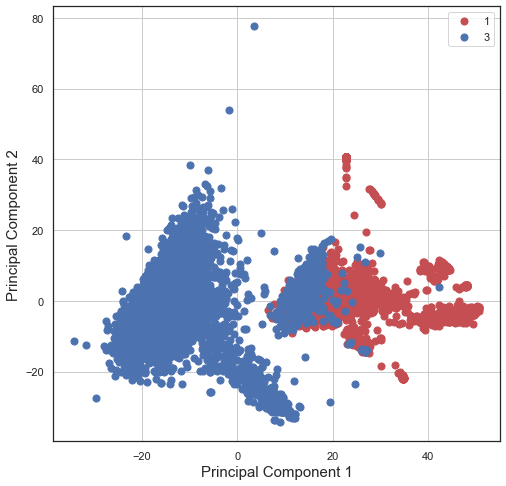

In [21]:
delta_principalDf = pd.DataFrame(data = x_delta_pca[:, :2], columns = ['principal component 1', 'principal component 2'])
# Need to reset the index of the target_df to match the new finalDF
re_target_df = target_df.reset_index(drop=True)
delta_finalDf = pd.concat([delta_principalDf, re_target_df[['is_obf']]], axis=1)

targets = [1, 3]
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
colors = ['r', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = delta_finalDf['is_obf'] == target
    ax.scatter(delta_finalDf.loc[indicesToKeep, 'principal component 1']
               , delta_finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Not bad. I think an investigation into outliers could help

+ 3D plot of delta

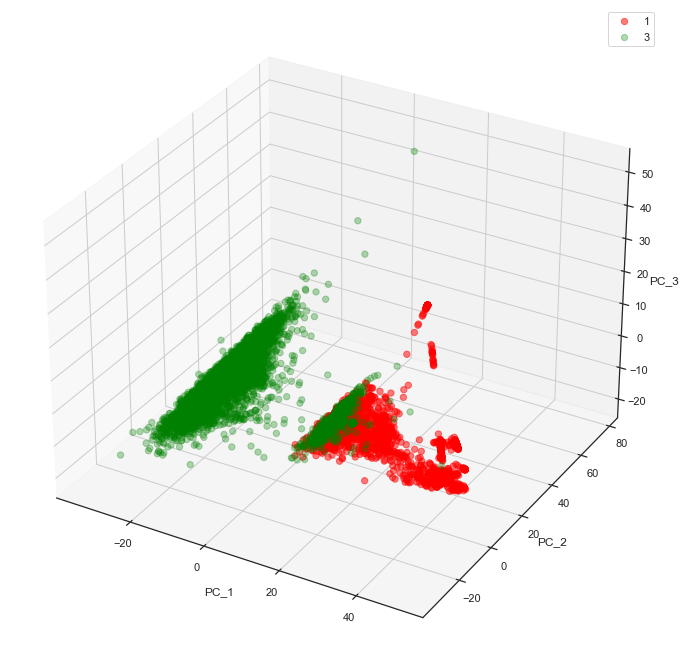

In [22]:
# Start 3D plotting of delta data
delta_3d_df = pd.DataFrame(data = x_delta_pca[:, :3], columns = ['PC_1', 'PC_2', 'PC_3'])
delta_3d_final_df = pd.concat([delta_3d_df, re_target_df[['is_obf']]], axis=1)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection = '3d')

cdict = {1:'red',3:'green'}
labl = {1:'1',3:'3'}
#marker = {1:'*',3:'o'}
alpha = {1:.5, 3:.3}

delta_3d_x = x_delta_pca[:, 0]
delta_3d_y = x_delta_pca[:, 1]
delta_3d_z = x_delta_pca[:, 2]

for l in np.unique(target_nd):
    ix=np.where(target_nd==l)
    ax.scatter(delta_3d_x[ix], delta_3d_y[ix], delta_3d_z[ix], c=cdict[l], s=40,
               label=labl[l],  alpha=alpha[l])

ax.set_xlabel("PC_1")
ax.set_ylabel("PC_2")
ax.set_zlabel("PC_3")

#ax.scatter(delta_3d_x, delta_3d_y, delta_3d_z)
ax.legend()
plt.show()

+ Original Data

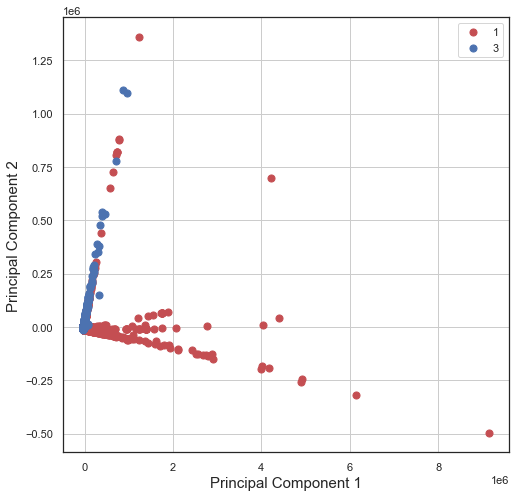

In [23]:
orig_principalDf = pd.DataFrame(data = x_orig_pca, columns = ['principal component 1', 'principal component 2'])
# Need to reset the index of the target_df to match the new finalDF
re_target_df = target_df.reset_index(drop=True)
orig_finalDf = pd.concat([orig_principalDf, re_target_df[['is_obf']]], axis=1)

targets = [1, 3]
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
colors = ['r', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = orig_finalDf['is_obf'] == target
    ax.scatter(orig_finalDf.loc[indicesToKeep, 'principal component 1']
               , orig_finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# The n_components might explain more in fewer...but the graph does not explain much